## Linear Regression

In [1]:
import math
import pymc as pm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

We can generate an example dataset by adding noise to a simple linear relationship.

In [2]:
N = 10

maxY = 15

c = 3
m = 2

x = np.linspace(1, N, N)
y = np.minimum(m * x + c, maxY) + np.random.normal(size=N)

A plot of y against x looks roughly linear with a flat top.

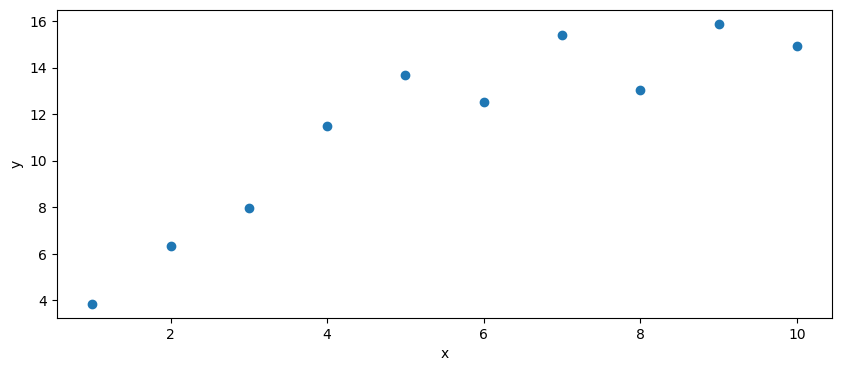

In [3]:
plt.figure(figsize=(10, 4))
plt.plot(x, y, 'o');
plt.xlabel('x')
plt.ylabel('y');

We can describe the same model with probablistic programming.

In [4]:
model = pm.Model() 

with model:
    
    m = pm.Normal('m', mu=0.0, sigma=1.0)

    c = pm.Normal('c', mu=0.0, sigma=1.0)
    
    sd = pm.Exponential('sd', lam=1.0)

    maxY = pm.Exponential('maxY', lam=1.0)

    mu = pm.math.minimum(m * x + c, maxY)

    obs = pm.ConstantData('obs', y)
    
    Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sd, observed=obs)

In [5]:
with model:
    
    idata = pm.sample(draws=2000)

In [12]:
pm.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
m,2.486,0.303,1.880,3.049,0.007,0.005,1991.0,2269.0,1.0
c,0.924,0.770,-0.568,2.298,0.017,0.012,2108.0,2400.0,1.0
sd,1.266,0.376,0.673,1.889,0.010,0.007,1539.0,1888.0,1.0
maxY,14.036,0.650,12.729,15.226,0.016,0.011,1935.0,1568.0,1.0


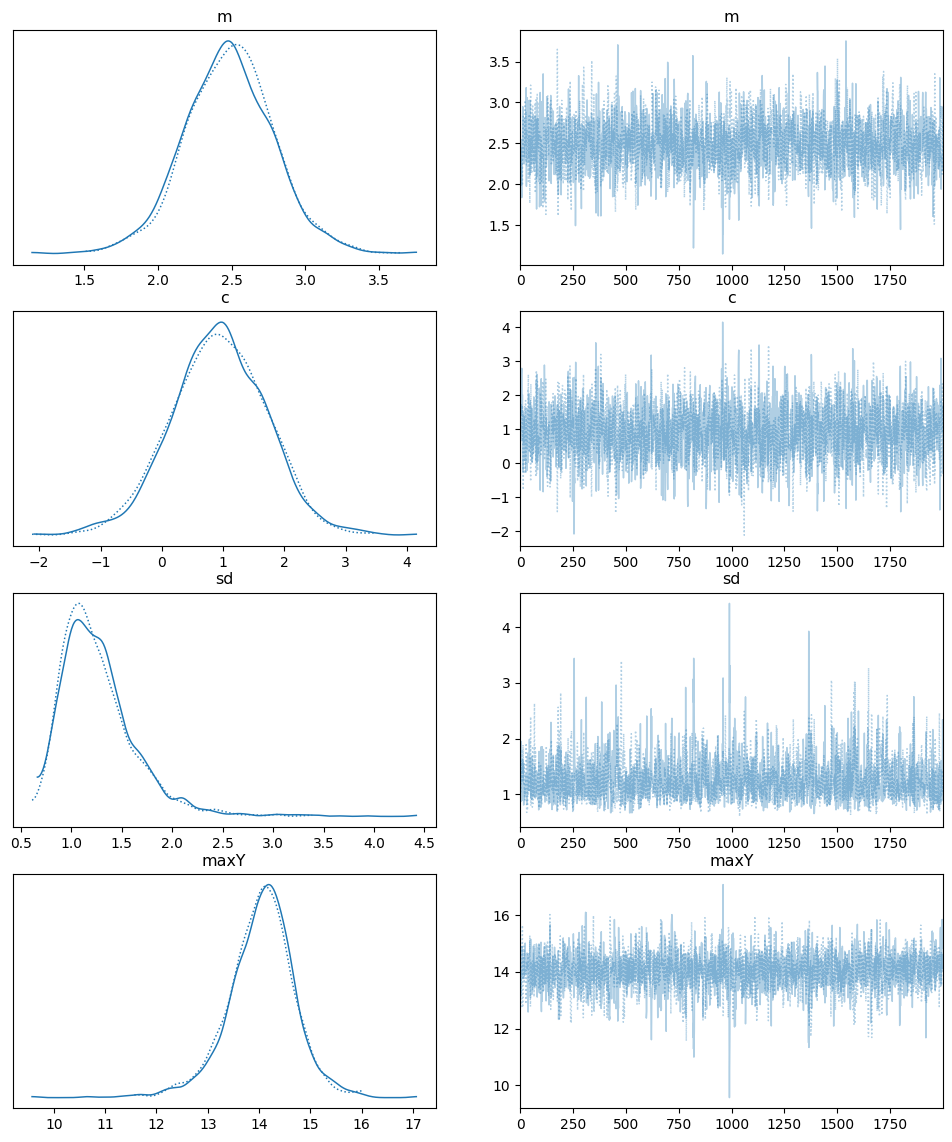

In [10]:
pm.plot_trace(idata, var_names=['m', 'c', 'sd', 'maxY'], combined=False, figsize=(12,14));

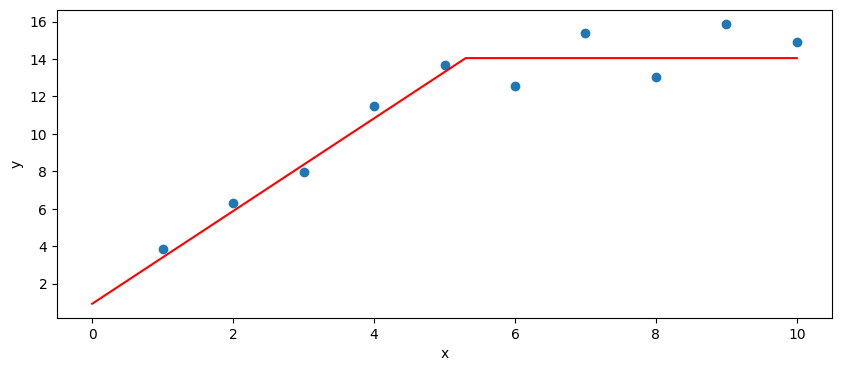

In [11]:
m = np.mean(np.asarray(idata.posterior.get('m')[0]))
c = np.mean(np.asarray(idata.posterior.get('c')[0]))
maxY = np.mean(np.asarray(idata.posterior.get('maxY')[0]))

x_predict = np.linspace(0, 10, 1001)
y_predict = np.minimum(m * x_predict + c, maxY)

plt.figure(figsize=(10, 4))
plt.plot(x, y, 'o');
plt.plot(x_predict, y_predict, 'r');
plt.xlabel('x')
plt.ylabel('y');